# Report II

Samples have been preprocessed and saved to a hdf5 file. Let's visualize some of them!

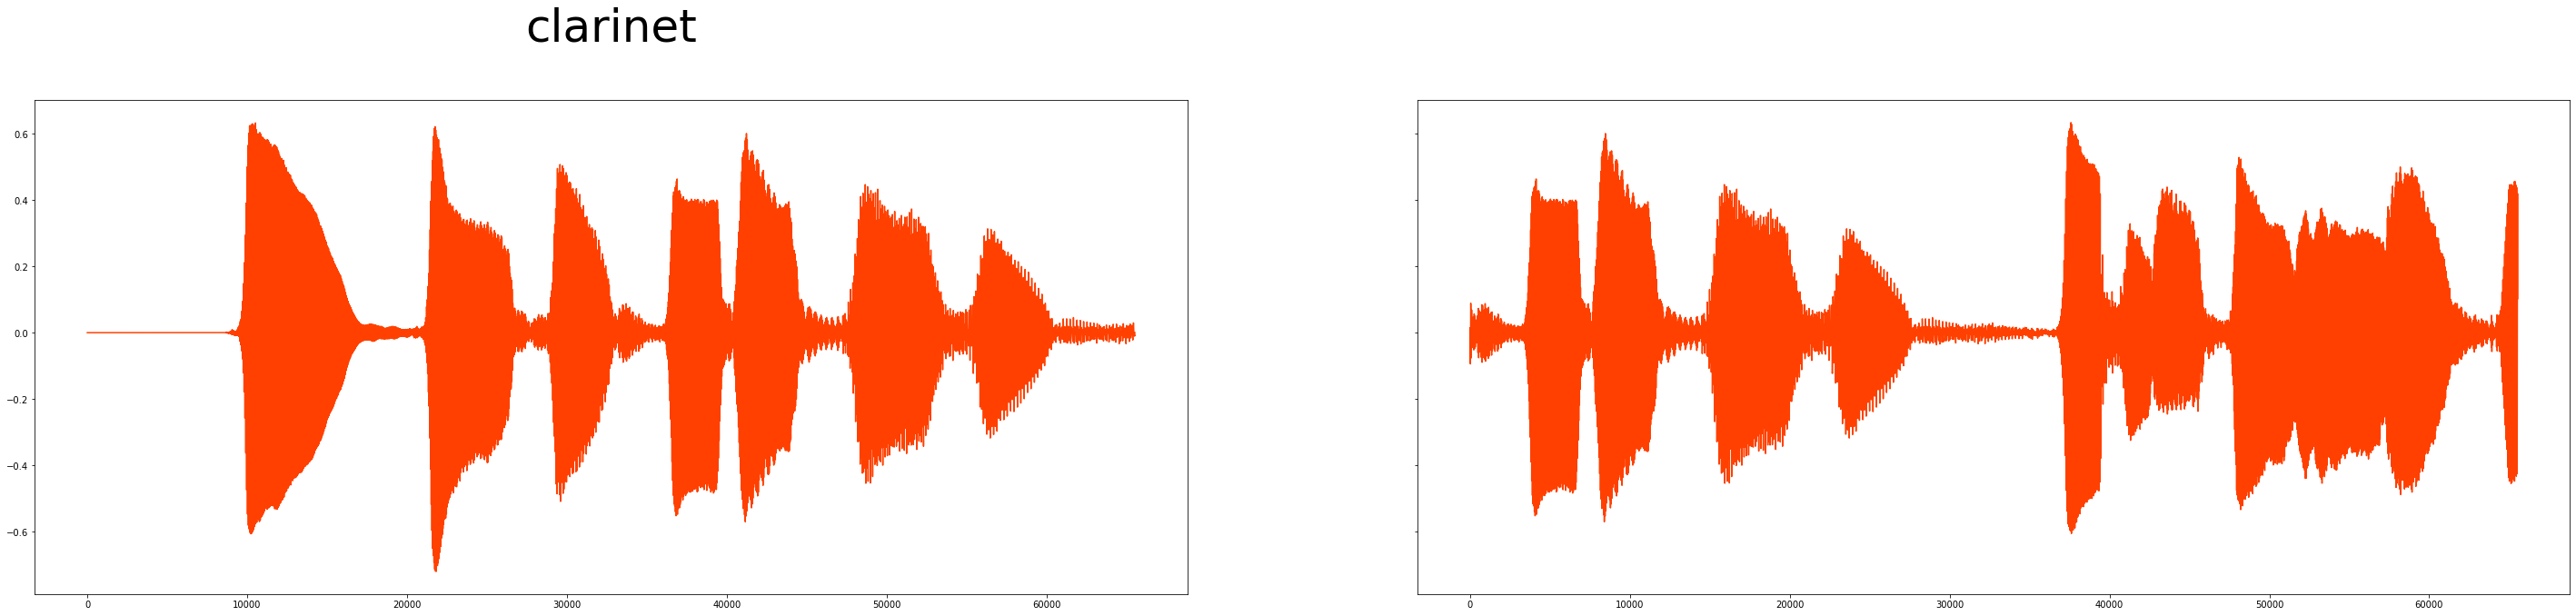

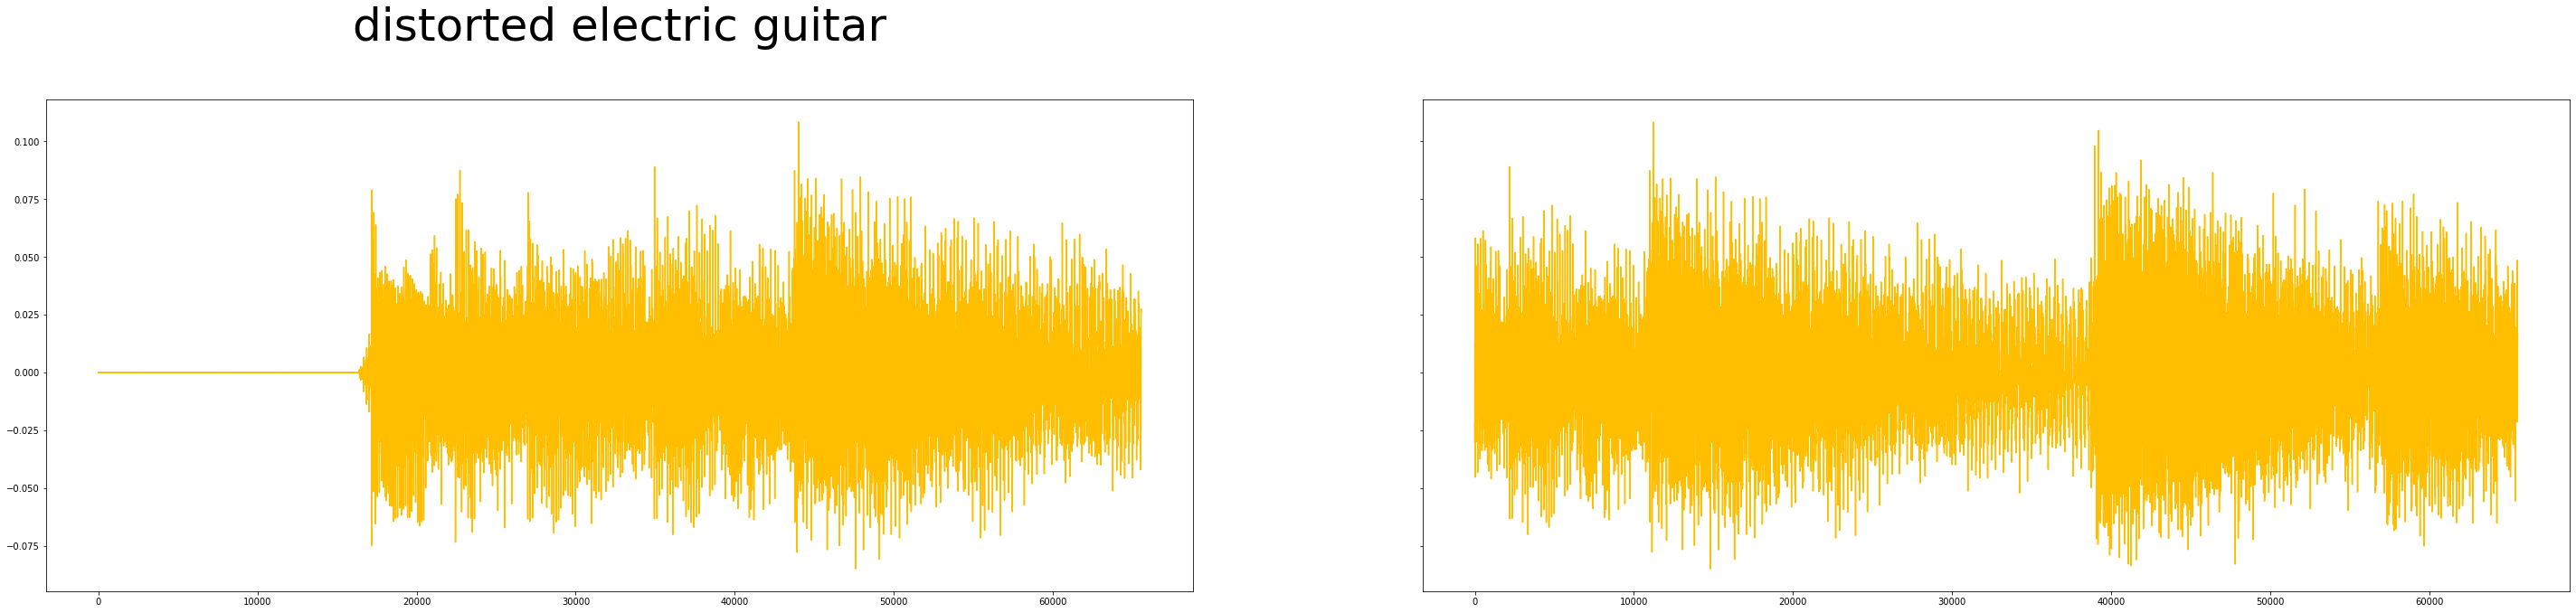

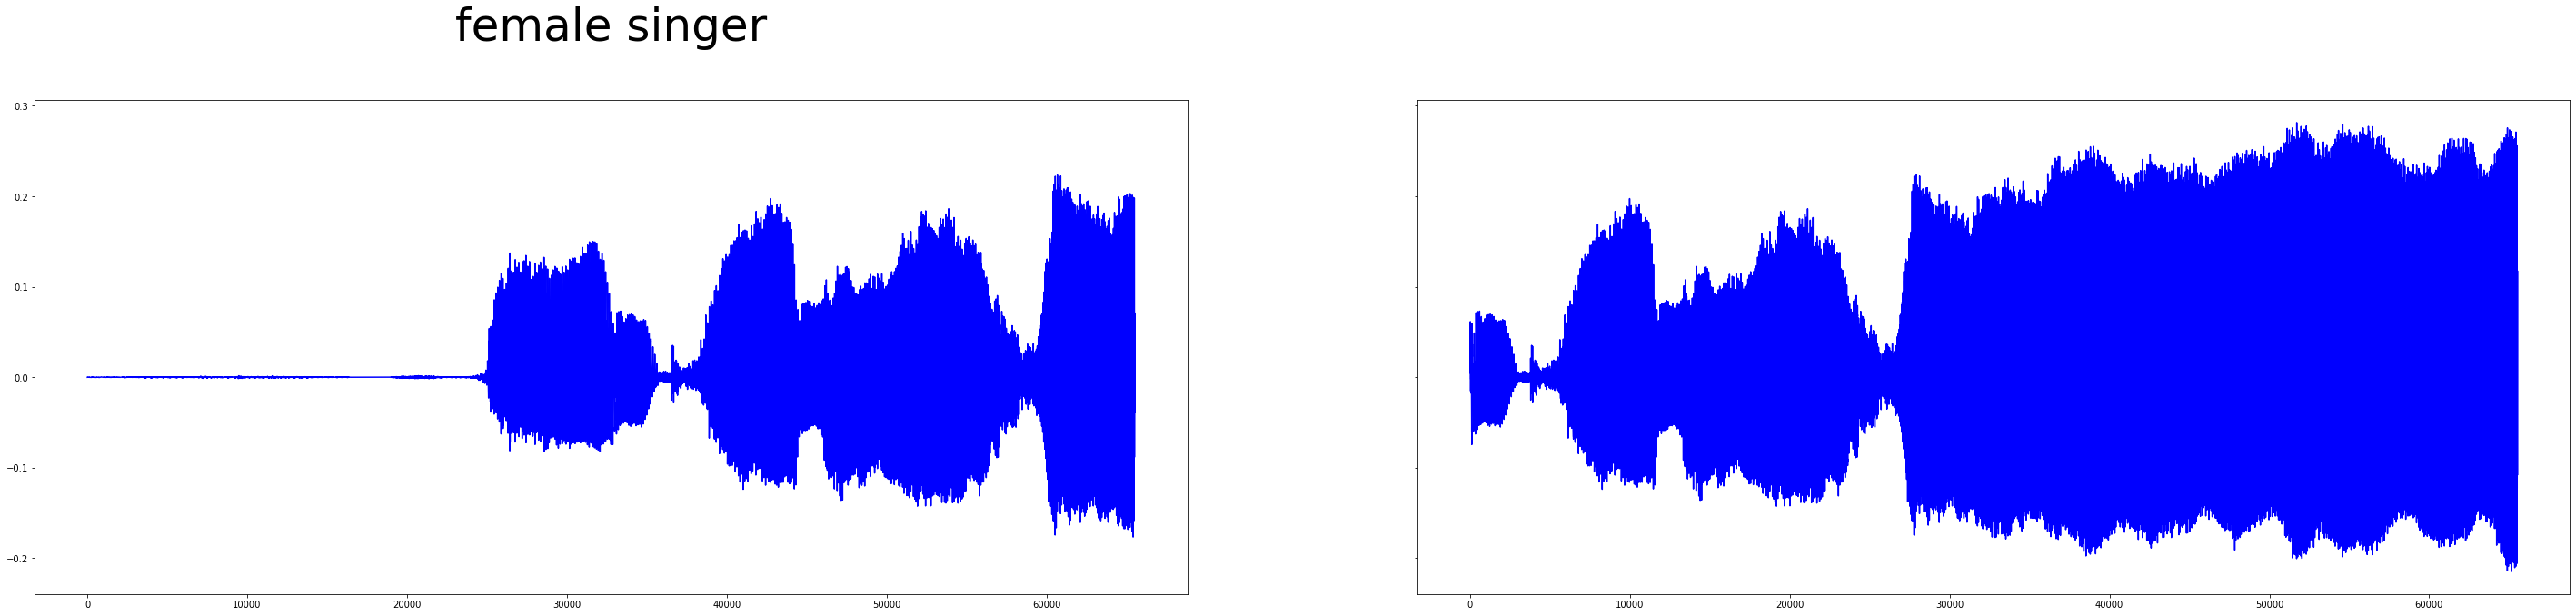

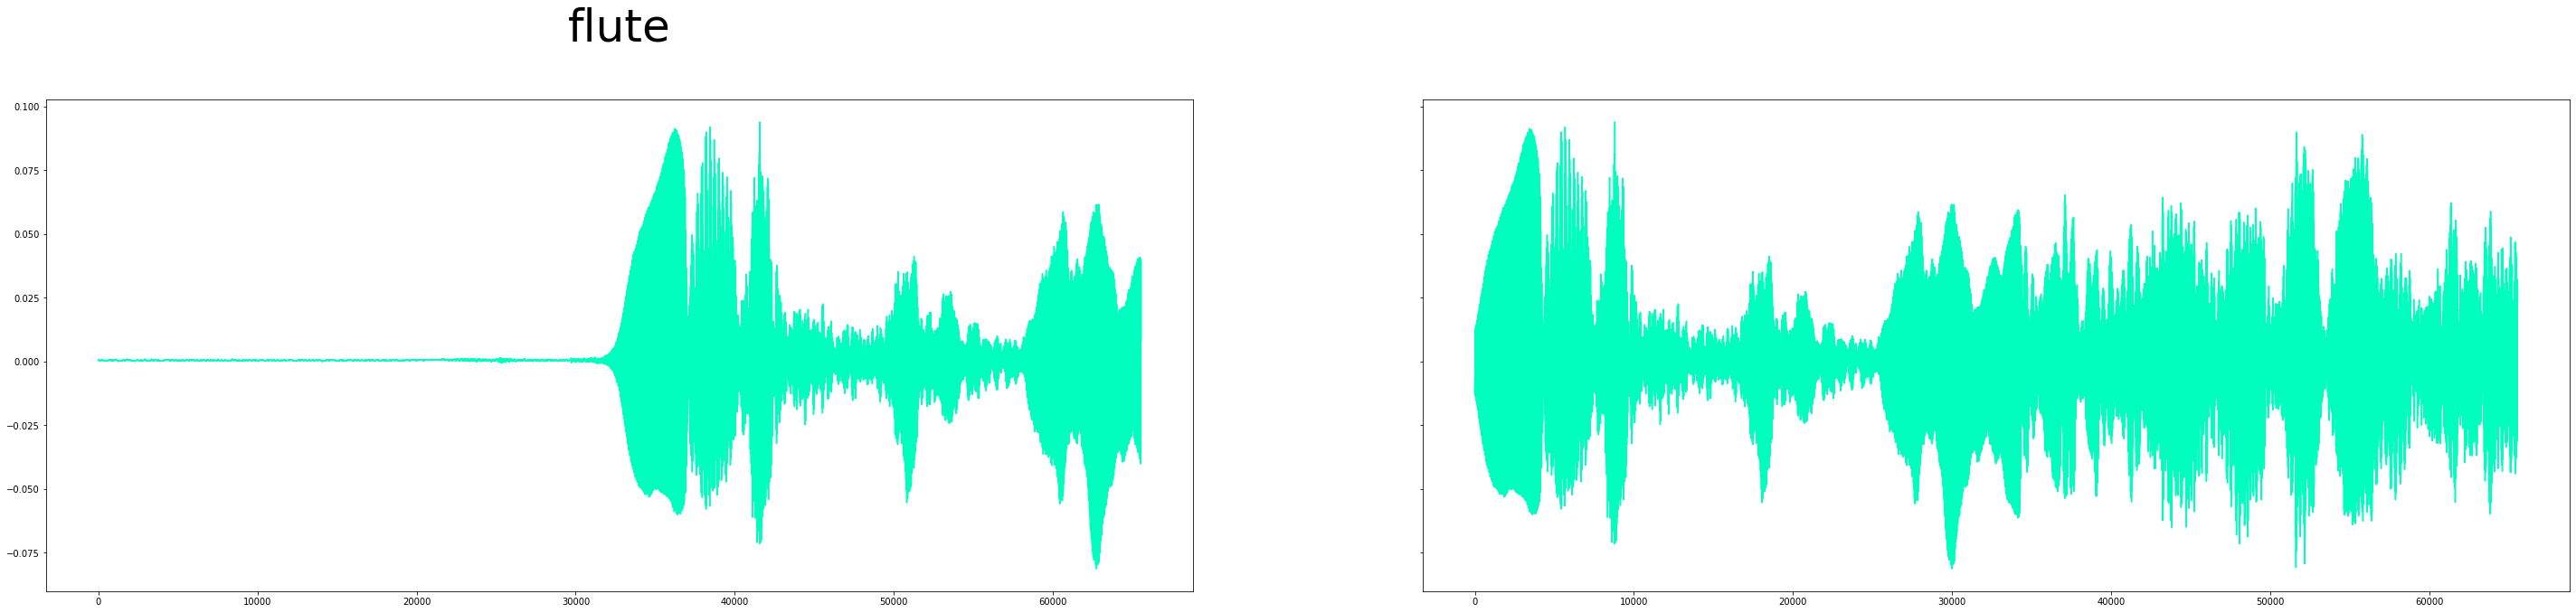

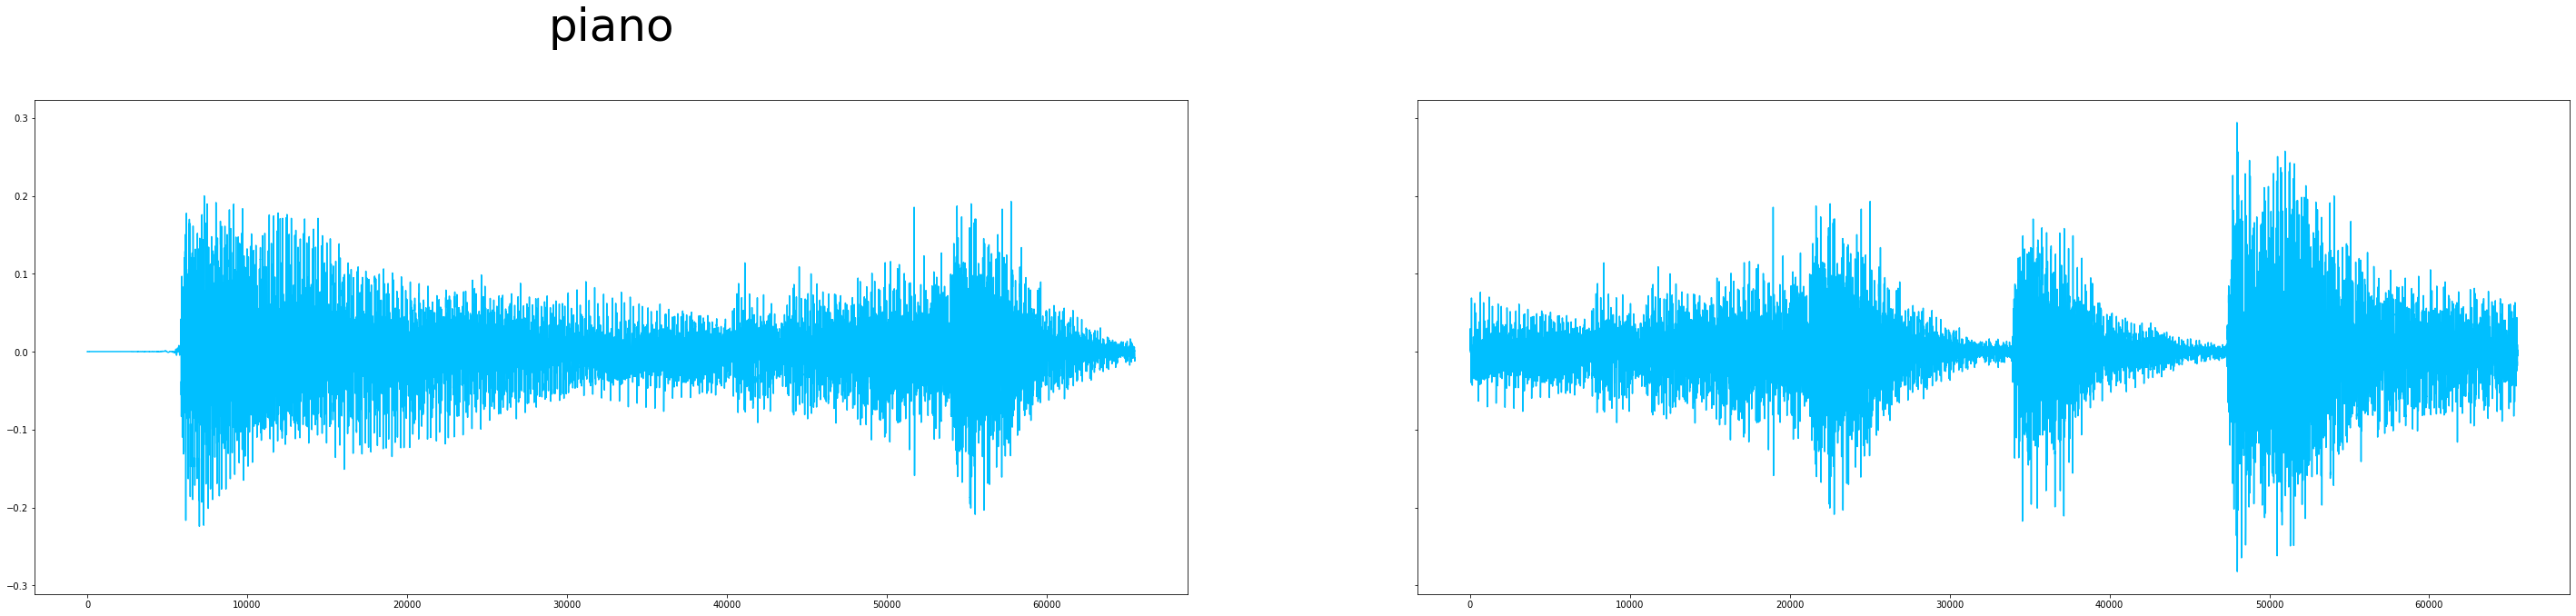

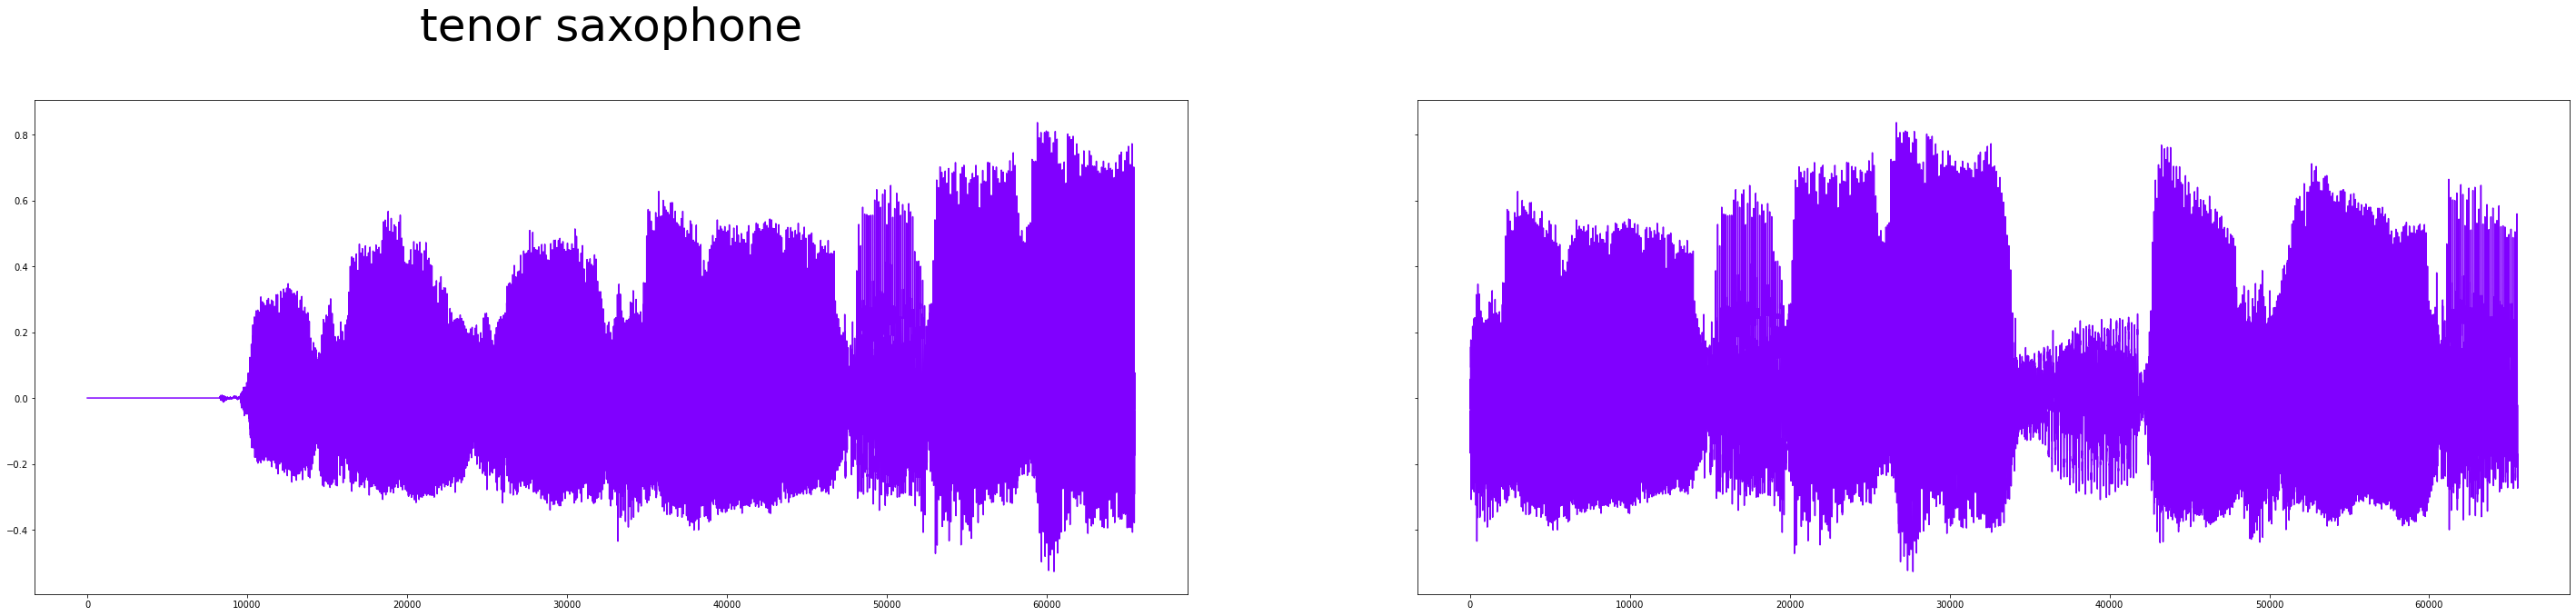

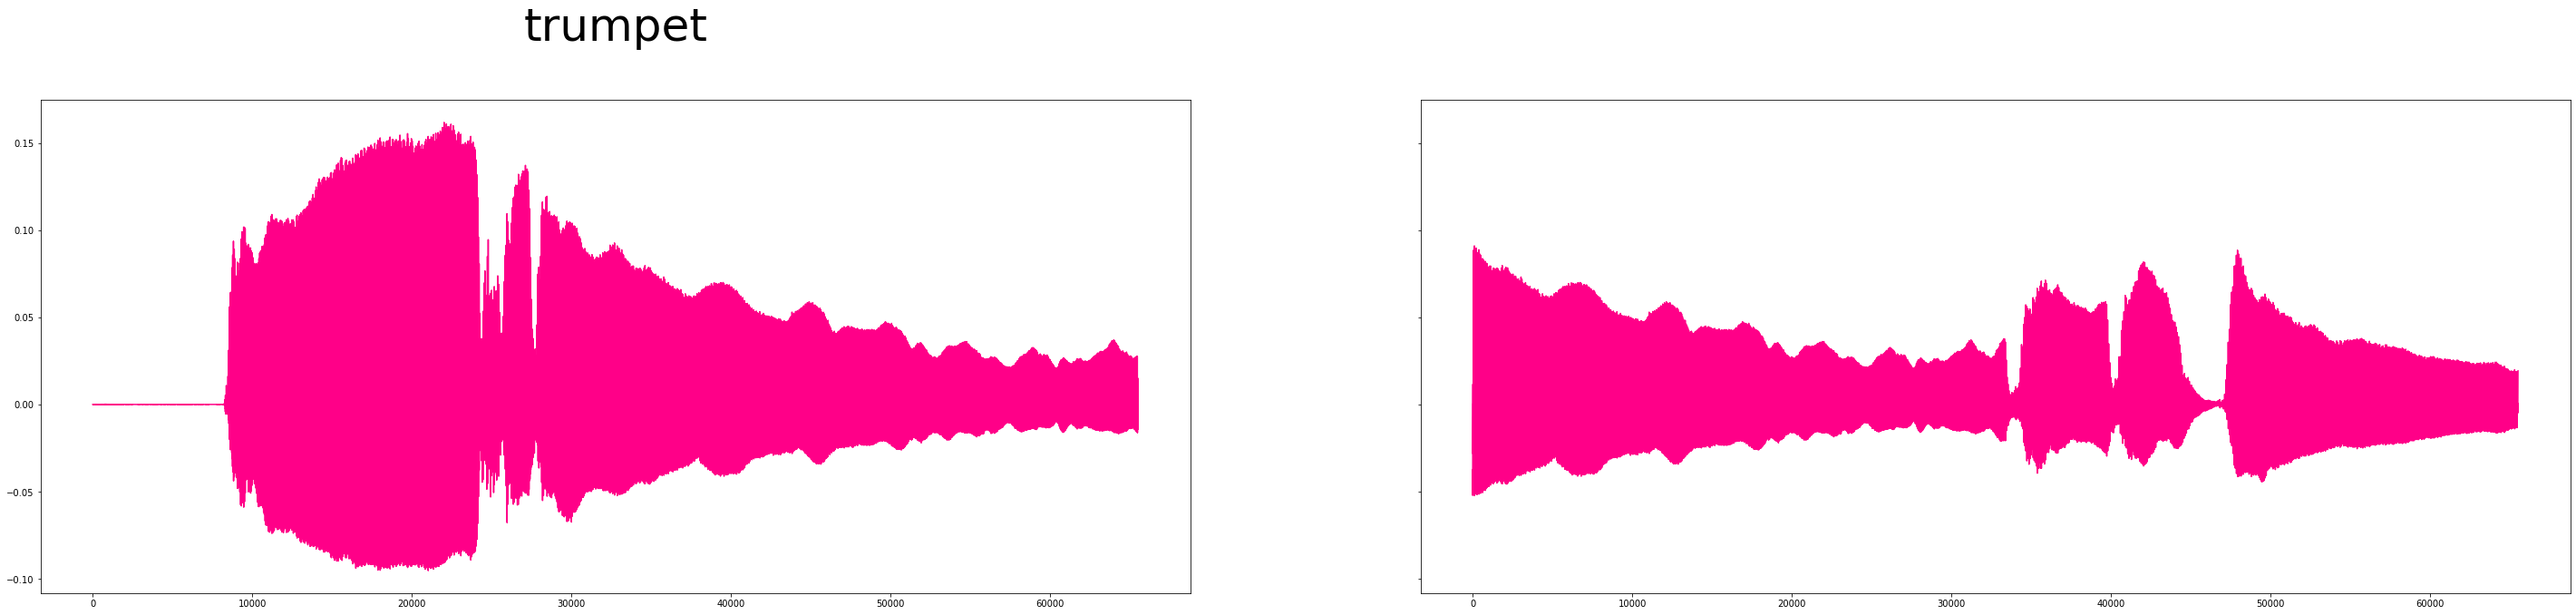

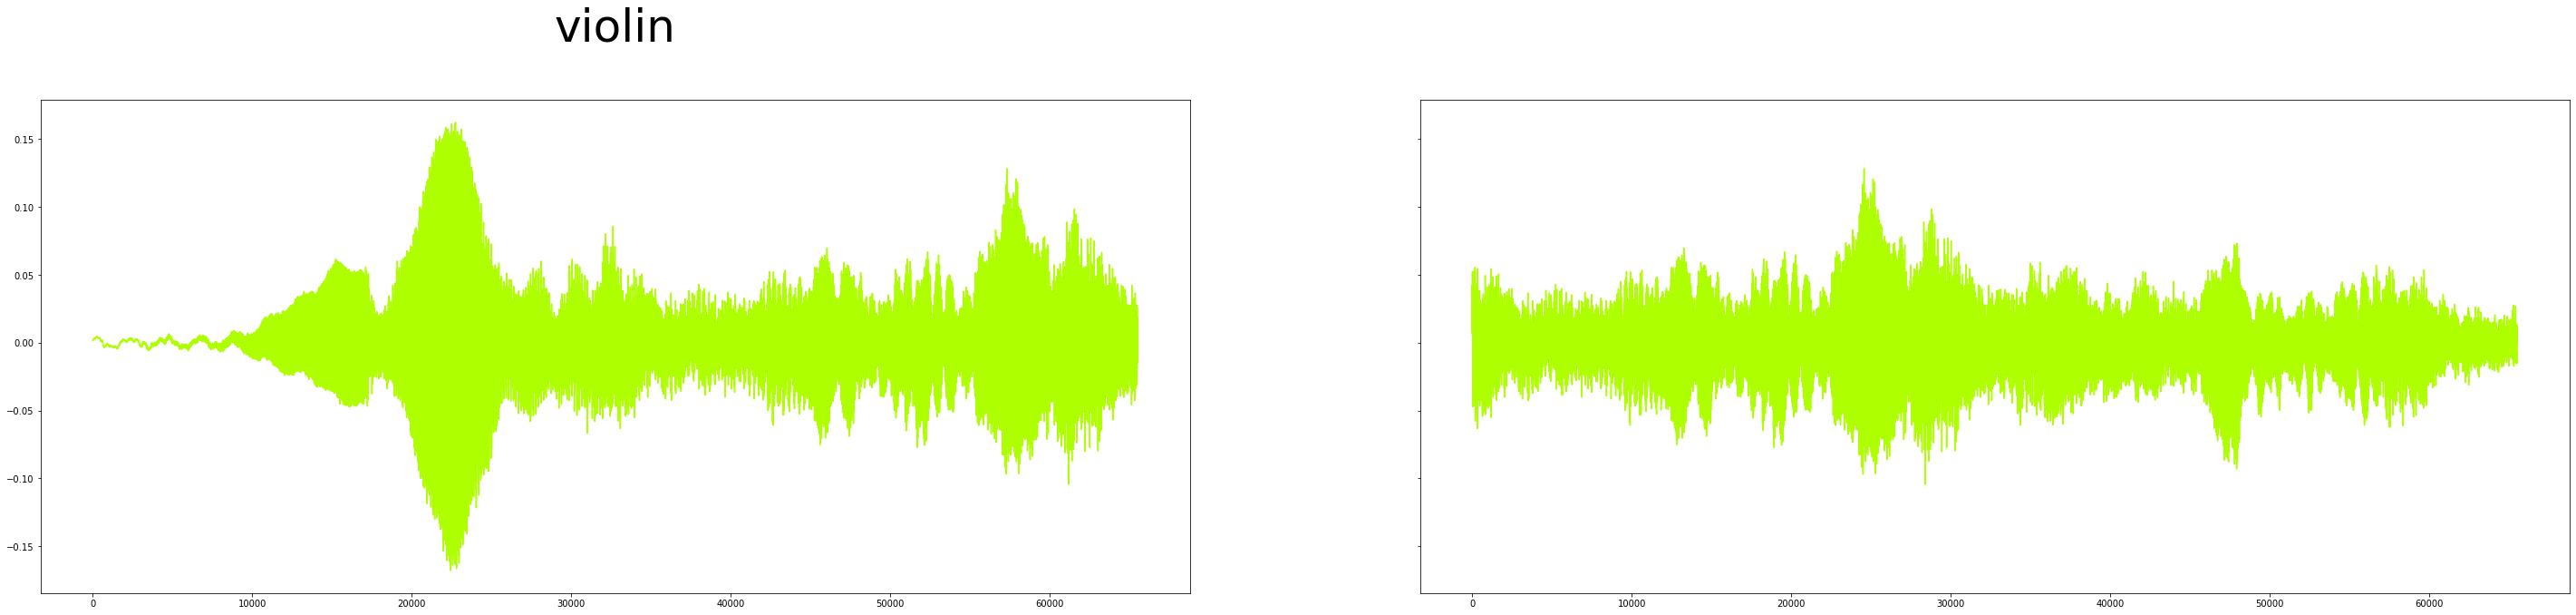

In [1]:
import json

import matplotlib.pyplot as plt

from src.common.audioviz_dataset import AudiovizDataset
from src.common.evaluation import format_metrics, eval_metrics, normalize_scores
from src.dimred.dimred import apply_dimred
from src.features.build_features import get_features, parse_feature_extractor
from src.visualization.visualize import plot2D
from src.visualization.visualize import plot_samples


ds = AudiovizDataset.load("medley_solos_db")

with ds._store:
    for cls, sample_indexes in enumerate(ds.get_samples_for_each_class()):
        plot_samples(
            [ds.data[i] for i in sample_indexes], ds.target_names[cls], ds.colors[cls]
        )

# Feature extraction

As of now two features have been extracted.

## stft

In [2]:
stft = {"name": "stft", "args": {}}
stft_fe = parse_feature_extractor(json.dumps(stft))

mfcc = {"name": "mfcc", "args": {}}
mfcc_fe = parse_feature_extractor(json.dumps(mfcc))


features = [stft, mfcc]

dataset = AudiovizDataset.load("medley_solos_db")
feature_collection = get_features(dataset, features)

2020-12-16 00:00:44,535 - root - INFO - Successfully Decoded function call stft().
2020-12-16 00:00:44,536 - root - INFO - Successfully Decoded function call mfcc().
2020-12-16 00:00:44,539 - root - INFO - Successfully Decoded function call stft().
2020-12-16 00:00:44,541 - root - INFO - Successfully Decoded function call mfcc().


STFT feature shape: (32, 32)


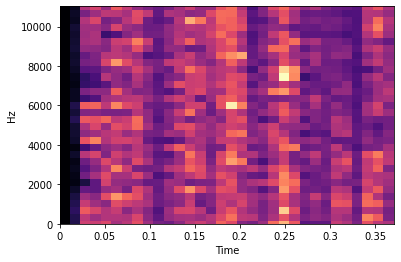

In [3]:
with feature_collection._store:
    stft_features = feature_collection[stft_fe]
    import librosa.display
    librosa.display.specshow(
        stft_features[0], y_axis="linear", x_axis="time", hop_length=1024 / 4
    )
    print(f"STFT feature shape: {stft_features[0].shape}")

MFCC feature shape: (20, 257)


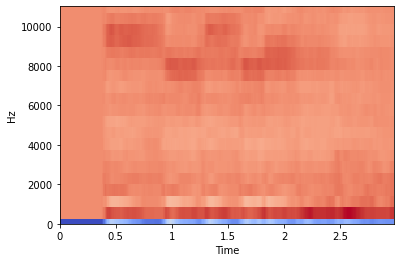

In [4]:
with feature_collection._store:
    mfcc_features = feature_collection[mfcc_fe]
    librosa.display.specshow(
        mfcc_features[0], y_axis="linear", x_axis="time", hop_length=1024 / 4
    )
    print(f"MFCC feature shape: {mfcc_features[0].shape}")

# Dimensionality reduction

## Grid search over stft umap parameters

2020-12-16 00:00:44,756 - root - INFO - Successfully Decoded function call umap(n_neighbors=5 min_dist=0.0 metric=correlation).
2020-12-16 00:00:44,756 - root - INFO - Successfully Decoded function call umap(n_neighbors=5 min_dist=0.001 metric=correlation).
2020-12-16 00:00:44,757 - root - INFO - Successfully Decoded function call umap(n_neighbors=5 min_dist=0.01 metric=correlation).
2020-12-16 00:00:44,767 - root - INFO - Successfully Decoded function call umap(n_neighbors=5 min_dist=0.1 metric=correlation).
2020-12-16 00:00:44,768 - root - INFO - Successfully Decoded function call umap(n_neighbors=5 min_dist=0.5 metric=correlation).
2020-12-16 00:00:44,770 - root - INFO - Successfully Decoded function call umap(n_neighbors=10 min_dist=0.0 metric=correlation).
2020-12-16 00:00:44,771 - root - INFO - Successfully Decoded function call umap(n_neighbors=10 min_dist=0.001 metric=correlation).
2020-12-16 00:00:44,771 - root - INFO - Successfully Decoded function call umap(n_neighbors=10 mi

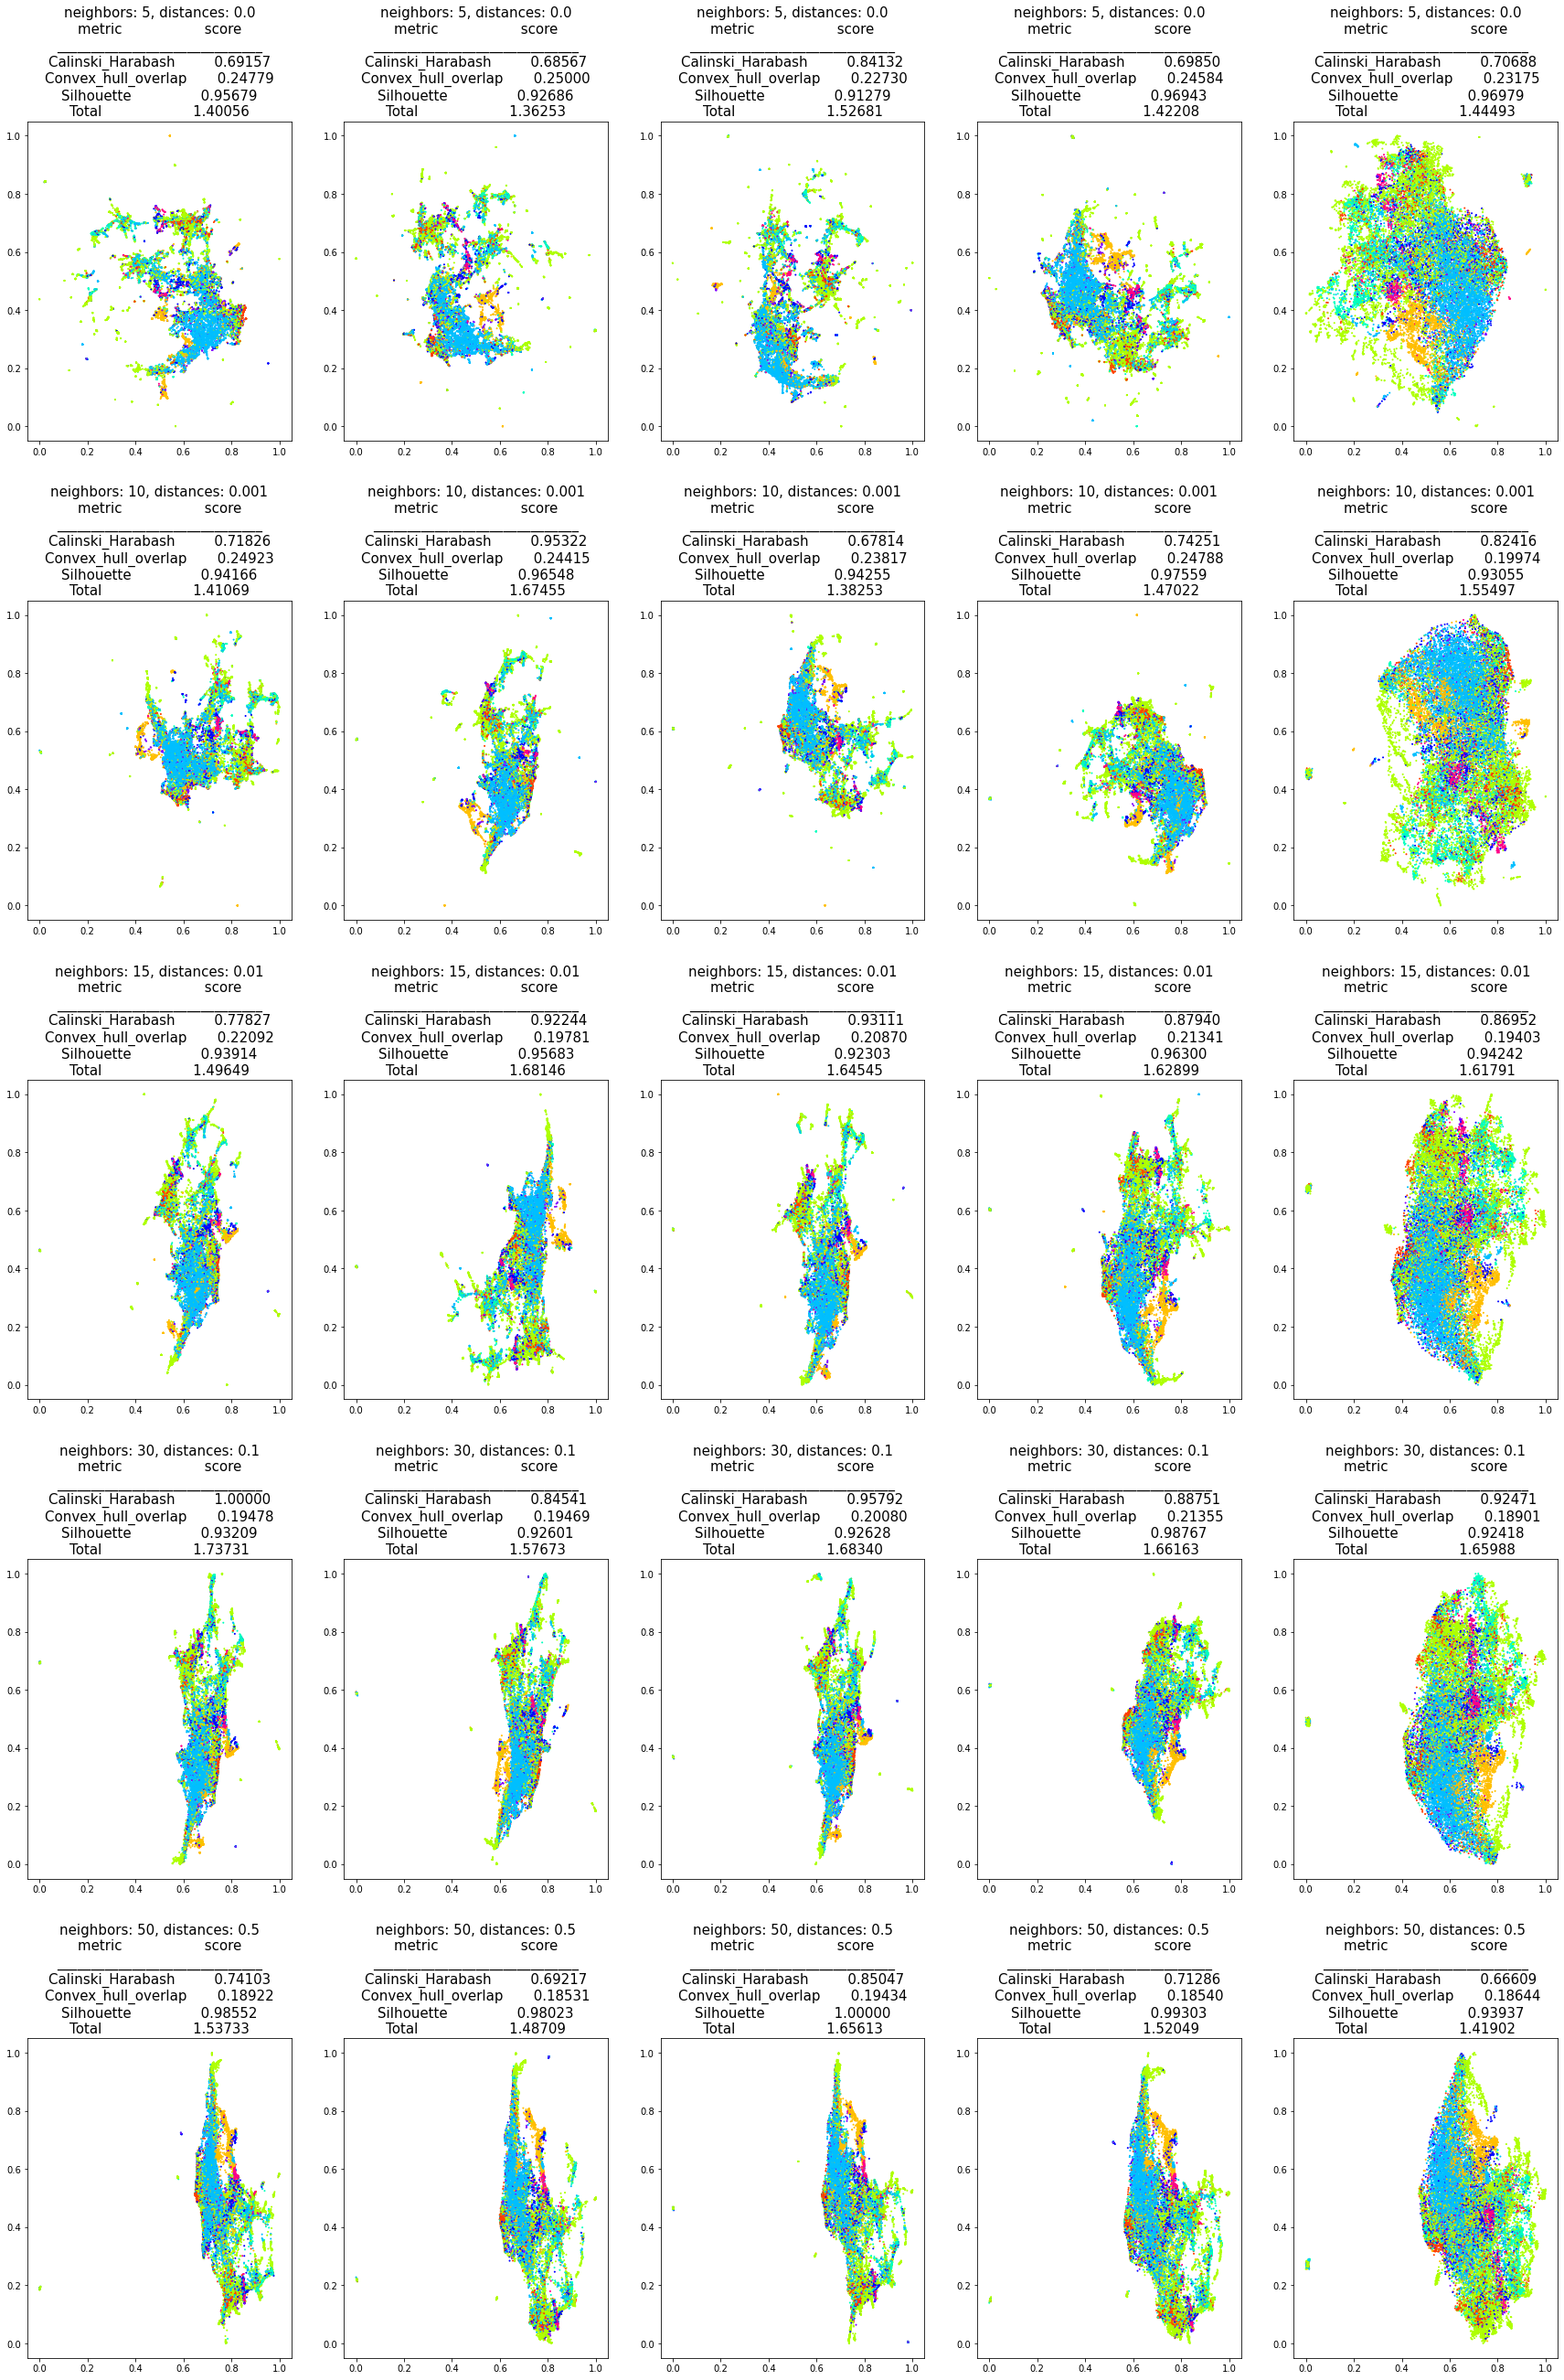

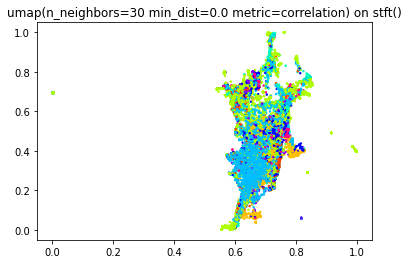

metric                   score
______________________________
Calinski_Harabash         1.00000
Convex_hull_overlap       0.19478
Silhouette                0.93209
Total                     1.73731


In [5]:
    stft = {"name": "stft", "args": {}}
    features = [stft]

    pca_alg = {"name": "pca", "args": {}}

    # Grid search over umap parameters
    n_neighbors = [5, 10, 15, 30, 50]
    min_dists = [0.000, 0.001, 0.01, 0.1, 0.5]
    umap_algs = [
        {
            "name": "umap",
            "args": {"n_neighbors": n, "min_dist": d, "metric": "correlation"},
        }
        for n in n_neighbors
        for d in min_dists
    ]
    dimred_algs = umap_algs

    dataset = AudiovizDataset.load("medley_solos_db")
    dimred_collection, algs, feature_collection = apply_dimred(
        dataset, dimred_algs, features
    )

    with feature_collection._store, dataset._store, dimred_collection:
        color_map = [dataset.colors[t] for t in dataset.target]
        scores = normalize_scores(dimred_collection, dataset.target, algs)

        fig, ax = plt.subplots(
            nrows=len(n_neighbors), ncols=len(min_dists), figsize=(30, 45)
        )

        for i, row in enumerate(ax):
            for j, col in enumerate(row):
                current_plot = i * len(min_dists) + j
                current_reduced = dimred_collection[algs[current_plot].__repr__()]
                col.scatter(
                    current_reduced[:, 0], current_reduced[:, 1], c=color_map, s=1
                )
                col.set_title(
                    f"neighbors: {n_neighbors[i]}, distances: {min_dists[i]}\n{format_metrics(scores[current_plot])}",
                    fontdict={"fontsize": 15},
                )
        plt.subplots_adjust(hspace=0.5)
        plt.show()
        total_scores = [s["Total"] for s in scores]
        max_score = max(total_scores)
        max_index = total_scores.index(max_score)
        plot2D(
            dimred_collection[algs[max_index].__repr__()],
            color_map,
            str(algs[max_index]),
            str(feature_collection),
        )
        print(format_metrics(scores[max_index]))